In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("..")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

pd.set_option('display.max_rows', 500)
relativePathImages = '../latex/src/images/'

## Obtengo el listado de palabras que aparecen más de 40 veces y dichas por más de 5 usuarios

In [3]:
import re
from scipy.stats import entropy

df = pd.read_csv("../contrastes/provincias.csv", quotechar="\"", decimal=",")
df = df.set_index("palabra")

fnorm_vars = [c for c in df.columns if re.match(r'fnorm_.*', c)]
cant_palabras = [c for c in df.columns if re.match(r'.*Palabras$', c)]
cant_personas = [c for c in df.columns if re.match(r'.*Personas$', c)]

Calculo la entropía de las palabras y de las personas, así como de las cantidades reordenadas aleatoriamente. 

También agrego la columna de las frecuencias normalizadas.

In [4]:
from iv_helpers import simulated_shuffled_entropy_multinomial
np.random.seed(seed=1)
fn = lambda ws: simulated_shuffled_entropy_multinomial(ws, len(cant_palabras))

df["entropy_palabras"] = df[cant_palabras].apply(entropy, axis=1, raw=True)
df["entropy_personas"] = df[cant_personas].apply(entropy, axis=1, raw=True)
df["shuffled_entropy_personas"] = df.cantUsuariosTotal.apply(fn)
df["shuffled_entropy_palabras"] = df.cantPalabra.apply(fn)
cantPalabrasTotales = sum(df.cantPalabra)
df['fnormArgentina'] = df['cantPalabra']/cantPalabrasTotales

Si le aplico el logaritmo a la cantidad de la Palabra, ya no tiene tanta importancia la cantidad y por lo tanto, las palabras palabras comunes como **que**, **y**,**el**,etc. dejan de tener tanto valor de información

In [85]:
import math
df['normCantPalabras']=(df.cantPalabra.apply(math.log,args=(2,))-df.cantPalabra.apply(math.log,args=(2,)).min())/(df.cantPalabra.apply(math.log,args=(2,)).max()-df.cantPalabra.apply(math.log,args=(2,)).min())
df['normCantPersonas']=(df.cantUsuariosTotal.apply(math.log,args=(2,))-df.cantUsuariosTotal.apply(math.log,args=(2,)).min())/(df.cantUsuariosTotal.apply(math.log,args=(2,)).max()-df.cantUsuariosTotal.apply(math.log,args=(2,)).min())
# df['normCantPalabras']=(df.cantPalabra-df.cantPalabra.mean())/(df.cantPalabra.std())
# df['normCantPersonas']=(df.cantUsuariosTotal-df.cantUsuariosTotal.mean())/(df.cantUsuariosTotal.std())
# df['normCantPalabras']=(df.cantPalabra-df.cantPalabra.min())/(df.cantPalabra.max()-df.cantPalabra.min()) 
# df['normCantPersonas']=(df.cantUsuariosTotal-df.cantUsuariosTotal.min())/(df.cantUsuariosTotal.max()-df.cantUsuariosTotal.min())


Agrego la columna *esLugar* para poder filtrar las palabras más rapidamente

In [6]:
from iv_helpers import lugares
places = lugares()
print len(places)
df['esLugar'] = np.where(df.index.str.decode(encoding='utf-8').isin(places),'lugar','ok')

3006


### Normalizo el valor de la cantidad de ocurrencias de una palabra y de usuarios que la utilizan.

$$ norm_{CantPalabras} = \frac{log_2(\#Palabra)- min(log_2(\#Palabra))}{max(log_2(\#Palabra)) - min(log_2(\#Palabra))}$$

$$norm_{CantPersonas} = \frac{log_2(\#Usuarios)- min(log_2(\#Usuarios))}{max(log_2(\#Usuarios)) - min(log_2(\#Usuarios))}$$

De esta forma, estos dos valores están en el rango 0-1

La métrica llamada $InformationValue_{PersonasPalabras}$

$$InformationValue_{PersonasPalabras} =  norm_{CantPalabras} * norm_{CantPersonas} * (\widehat{H}_{personas} - H_{personas}) * (\widehat{H}_{palabras} - H_{palabras})$$

donde $\widehat{H}$ es la entropía con las cantidades distribuidas uniformemente y H es la entropía común

In [7]:
import math

df["information_value_palabras"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_palabras - df.entropy_palabras)
df["information_value_personas"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_personas - df.entropy_personas)
# df["information_value_personas_palabras"] = (df.cantUsuariosTotal.apply(math.log,args=(2,))) * (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
# df["information_value_personas_palabras"] = df.normCantPalabras * df.normCantPersonas * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
df["information_value_personas_palabras"] = df.normCantPalabras * df.normCantPersonas * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
# df["information_value_personas_palabras"] = df.cantPalabra * df.cantUsuariosTotal * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)

df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=True)
df['rankPalabras'] = df['information_value_palabras'].rank(ascending=False).astype('int64')
df['rankPersonas'] = df['information_value_personas'].rank(ascending=False).astype('int64')
df['rankPalabras_Personas'] = df['information_value_personas_palabras'].rank(ascending=False).astype('int64')


palabrasPersonas = [c for c in df.columns if re.match(r'.*PalabrasPersonas', c)]
# df = df.set_index('palabra')
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
df.iloc[:1000][['fnormArgentina','cantPalabra','esLugar','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas','normCantPersonas','normCantPalabras','shuffled_entropy_personas','entropy_personas']]

,fnormArgentina,cantPalabra,esLugar,cantUsuariosTotal,provinciaFnormMax,rankPalabras,rankPersonas,rankPalabras_Personas,normCantPersonas,normCantPalabras,shuffled_entropy_personas,entropy_personas
palabra,,,,,,,,,,,,
chivilcoy,2.161422e-05,4074,lugar,469,buenosaires,4,5,1,0.532714,0.379500,3.101728,0.558161
oberá,2.292996e-05,4322,lugar,378,misiones,3,3,2,0.506352,0.384377,3.116717,0.569656
ushuaia,7.940069e-05,14966,lugar,1006,tierradelfuego,1,53,3,0.625981,0.486874,3.123585,1.453279
ush,1.133765e-05,2137,ok,465,tierradelfuego,11,4,4,0.531668,0.326256,3.121715,0.362702
obera,1.117318e-05,2106,lugar,410,misiones,17,10,5,0.516283,0.325050,3.115185,0.543877
breñas,1.374100e-05,2590,lugar,170,chaco,6,2,6,0.408690,0.342121,3.070409,0.232404
viedma,3.493079e-05,6584,lugar,666,rionegro,7,54,7,0.575573,0.419112,3.118042,1.294115
bragado,1.488166e-05,2805,lugar,294,buenosaires,9,11,8,0.475637,0.348702,3.086379,0.619135
logroño,1.375161e-05,2592,lugar,132,larioja,5,1,9,0.377771,0.342184,3.031223,0.089018


## Hago un dataframe con las palabras candidatas, cada una con las cantidades de ocurrencias por provincia de forma ordenada

In [8]:
cant = [c for c in df.columns if re.match(r'.*Palabras$', c) and (not re.match(r'.*norm', c) ) and (not re.match(r'.*rank', c) )]

dfCant = df[cant]
# Palabras candidatas según la AAL
palabras = ["quedarla","mitaí","angá","yungas","mensajeras","yarco","yarca",
"malpegar","malpegue","malpegada","tareferos","hartante","guaracha","esar","ñeri",
"piadina","chombi","achilata","pollerear","juntadera","pachata","chamigo","chamiga",
"chaque","pichar","tortita","guaso","guasa","comparsero","comparsera","sina","lape","veme","porronear",
"fajita","jia","jía","asada","asar","manso","cora","cumpa","pingo","charro","pinchila","oyo","ura","yuto",
"yagua","cantobar","cha","bombolo","bombola","yafu","jal","gatera","atina",
"guampudo","guampuda","mamila","chui","tico"]


In [9]:
dfC = df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=False)[cant]

In [10]:
sort_xs = dfC.apply(np.sort, axis=1)
sort_index = dfC.apply(np.argsort, axis=1)
sort_xs.columns = range(23)
sort_index.columns = range(23)
cols = sort_xs.columns.tolist()
cols = cols[::-1]
sort_xs = sort_xs[cols]
sort_index = sort_index[cols]
sort_xs.columns= range(23)
sort_index.columns = range(23)

In [11]:
percent = sort_xs.div(sort_xs.sum(axis=1), axis='index')
percent.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
palabra,,,,,,,,,,,,,,,,,,,,,
chivilcoy,0.979872,0.003682,0.003436,0.002209,0.001718,0.001227,0.000982,0.000982,0.000736,0.000736,...,0.000736,0.000491,0.000245,0.000245,0.000245,0.000245,0.000000,0.000000,0.000000,0.000000
oberá,0.981953,0.007867,0.003702,0.001157,0.000925,0.000925,0.000694,0.000463,0.000463,0.000463,...,0.000231,0.000231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ushuaia,0.962649,0.006749,0.004410,0.003140,0.002339,0.002205,0.002071,0.001938,0.001871,0.001670,...,0.001270,0.000935,0.000802,0.000735,0.000535,0.000535,0.000535,0.000535,0.000535,0.000267
ush,0.981750,0.006551,0.001404,0.001404,0.000936,0.000936,0.000936,0.000936,0.000936,0.000468,...,0.000468,0.000468,0.000468,0.000468,0.000468,0.000000,0.000000,0.000000,0.000000,0.000000
obera,0.962013,0.014245,0.005223,0.002374,0.002374,0.002374,0.001899,0.001899,0.001425,0.000950,...,0.000950,0.000475,0.000475,0.000475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


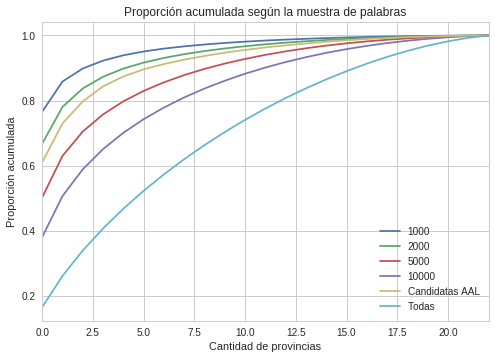

In [12]:
dfAcum = pd.DataFrame()
dfAcum['1000'] = percent.iloc[:1000].cumsum(axis=1).mean()
dfAcum['2000'] = percent.iloc[:2000].cumsum(axis=1).mean()
dfAcum['5000'] = percent.iloc[:5000].cumsum(axis=1).mean()
dfAcum['10000'] = percent.iloc[:10000].cumsum(axis=1).mean()
dfAcum['Candidatas AAL'] = percent.loc[palabras].cumsum(axis=1).mean()
dfAcum['Todas'] = percent.cumsum(axis=1).mean()
ax = dfAcum.plot(kind='line')

ax.set_xlabel(u"Cantidad de provincias")
ax.set_ylabel(u"Proporción acumulada")
ax.set_title(u'Proporción acumulada según la muestra de palabras')
ax2= ax.get_figure()
ax2.savefig("{0}PropAcum.pdf".format(relativePathImages),dpi=300)

In [13]:
dfAcum['1000'] = percent.iloc[:1000].cumsum(axis=1).mean()
dfAcum

,1000,2000,5000,10000,Candidatas AAL,Todas
0,0.765978,0.667815,0.502619,0.380862,0.610184,0.165523
1,0.858378,0.780477,0.630083,0.506757,0.729768,0.261680
2,0.898416,0.837181,0.704929,0.588935,0.797470,0.339650
3,0.922650,0.873071,0.757482,0.650990,0.843546,0.407328
4,0.938929,0.898167,0.797640,0.701089,0.873936,0.467869
5,0.950676,0.916567,0.829620,0.742823,0.895849,0.522942
6,0.959469,0.930808,0.855990,0.778537,0.912074,0.573430
7,0.966411,0.942454,0.878236,0.809596,0.925600,0.620024
8,0.972106,0.951972,0.897250,0.836870,0.936912,0.663217
9,0.976870,0.959999,0.913573,0.860955,0.946959,0.703381


In [14]:
df.iloc[:10000].cantPalabra.mean()

715.2056

In [15]:
df[(df.rankPalabras_Personas> 10000) &  ((df.rankPalabras< 2000) | (df.rankPersonas< 2000))][['entropy_personas','entropy_palabras','cantPalabra','cantUsuariosTotal','normCantPalabras','normCantPersonas']]

,entropy_personas,entropy_palabras,cantPalabra,cantUsuariosTotal,normCantPalabras,normCantPersonas
palabra,,,,,,
judejut,1.213008,0.838477,116,8,0.085824,0.035159
cmj,1.219137,1.055872,44,21,0.005827,0.153106
gift,3.058502,1.529343,1023,229,0.265465,0.445101
twich,1.643418,0.775350,71,10,0.045313,0.062430
biblico,1.791759,0.786223,142,12,0.102513,0.084713
modal,2.464508,0.970468,110,23,0.081441,0.164224
sojuela,0.000000,0.000000,56,7,0.025729,0.018839
salvia,2.306669,0.975751,101,16,0.074397,0.119872
confitear,0.178845,0.112516,42,23,0.001989,0.164224


In [16]:
df.loc['gift']

buenosairesPalabras                             11
catamarcaPalabras                                5
chacoPalabras                                    2
chubutPalabras                                  28
cordobaPalabras                                 12
corrientesPalabras                              11
entreriosPalabras                                6
formosaPalabras                                  7
jujuyPalabras                                   30
lapampaPalabras                                 16
lariojaPalabras                                706
mendozaPalabras                                 16
misionesPalabras                                 8
neuquenPalabras                                  6
rionegroPalabras                                22
saltaPalabras                                   16
sanjuanPalabras                                 20
sanluisPalabras                                 13
santacruzPalabras                               16
santafePalabras                

# Vemos como se distribuye la suma acumulada de proporciones de las palabras

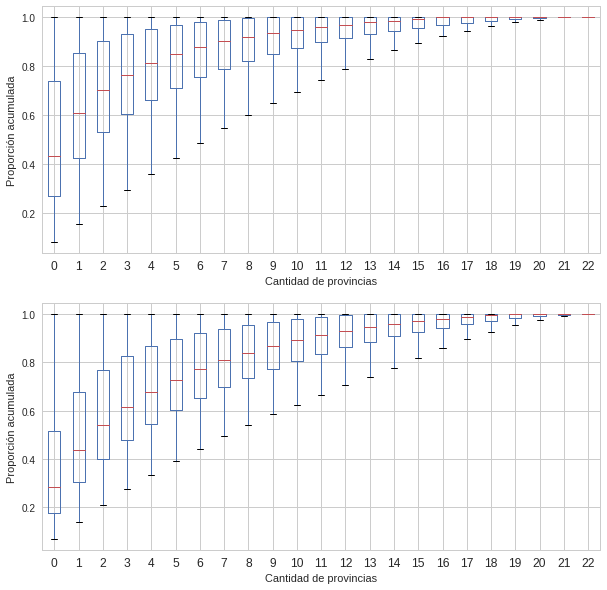

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,10))
ax = percent.iloc[:5000].cumsum(axis=1).boxplot(return_type='axes',ax=axes[0])
ax2 = percent.iloc[:10000].cumsum(axis=1).boxplot(return_type='axes',ax=axes[1])
# fig.subplots_adjust(hspace=.8)

ax.set_xlabel(u"Cantidad de provincias")
ax.set_ylabel(u"Proporción acumulada")
# ax.set_title(u'Proporción acumulada (primeras 5000 palabras)')

ax2.set_xlabel(u"Cantidad de provincias")
ax2.set_ylabel(u"Proporción acumulada")
# ax2.set_title(u'Proporción acumulada (primeras 10000 palabras)')
fig.savefig("{0}PropAcum5000.pdf".format(relativePathImages),dpi=300)

In [18]:
regiones = pd.DataFrame()
regiones = percent.cumsum(axis=1)
regiones
# regiones["thresh80"] =
def calc(row,thresh):
    for i in range(len(row)):
        if row[i]> thresh:
            return i+1
    
for thresh in np.arange(0.7,1,0.05):
    print "La media de provincias con threshold igual a " + str(thresh) + ": " + str(regiones[:5000].apply(calc,args=(thresh,),axis=1).mean())


La media de provincias con threshold igual a 0.7: 4.0424
La media de provincias con threshold igual a 0.75: 4.7482
La media de provincias con threshold igual a 0.8: 5.6118
La media de provincias con threshold igual a 0.85: 6.721
La media de provincias con threshold igual a 0.9: 8.264
La media de provincias con threshold igual a 0.95: 10.6422
La media de provincias con threshold igual a 1.0: 20.2752293578


### Me fijo la región que supera el úmbral por cada palabra

In [19]:
provincias = [x.replace("Palabras","") for x in cant]
def provs(row,thresh):
    for i in range(len(row)):
        if row[i]> thresh:
            cant = sort_index.loc[row.name].iloc[:i+1].tolist()
            return [provincias[x] for x in cant]

In [20]:
df['regionTest'] = regiones.apply(provs,args=(0.8,),axis=1)

In [21]:
def cantPalabrasTotalesEnRegion(provincias):
    return sum(dfR.loc[provincias,'cantTotal'])

def cantPalabrasWEnRegion(palabra,provincias):
    provs = [p+'Palabras' for p in provincias]
    return sum(dfcantPalabrasEnProvincia.loc[palabra,provs])
dfR = pd.read_csv('../cantidadesDataset.csv',index_col=0)
dfcantPalabrasEnProvincia = pd.read_csv("../contrastes/provincias.csv", quotechar="\"", decimal=",",index_col='palabra')


In [22]:
df['cantPalabrasTotalesEnRegion'] = df.regionTest.apply(cantPalabrasTotalesEnRegion)


In [23]:
df['cantPalabrasWEnRegion'] = df.apply(lambda x: cantPalabrasWEnRegion(x.name,x.regionTest),axis=1)


In [24]:
# cantidad de palabras con esa provincia que tiene mucha proporción de ocurrencias
provsMOcurrencia= pd.DataFrame(index=provincias)
for p in provincias:
    print  p +' '+ str(sum(df['regionTest'].apply(lambda x : p == x[0])))

buenosaires 4439
catamarca 2868
chaco 1835
chubut 3326
cordoba 5427
corrientes 2752
entrerios 3615
formosa 1587
jujuy 1857
lapampa 2850
larioja 4574
mendoza 4519
misiones 2175
neuquen 2735
rionegro 4329
salta 2940
sanjuan 3075
sanluis 2161
santacruz 2056
santafe 4692
santiago 1983
tierradelfuego 3626
tucuman 6457


In [25]:
cols = df.columns.tolist()
cols = [cols[-1]] + cols[:-1] 
    # "commit" the reordering
df = df[cols]

## Hago un dataframe con las palabras candidatas, cada una con las provincias ordenadas según cuantas veces ocurre una palabra en cada una de ellas

In [26]:
df.sort_values(by='information_value_personas_palabras',ascending=False,inplace=True)
df.iloc[:7000][['cantPalabra','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas']]
df.iloc[:7000][['cantPalabra','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas','entropy_palabras','entropy_personas']].to_csv('resumido.csv')

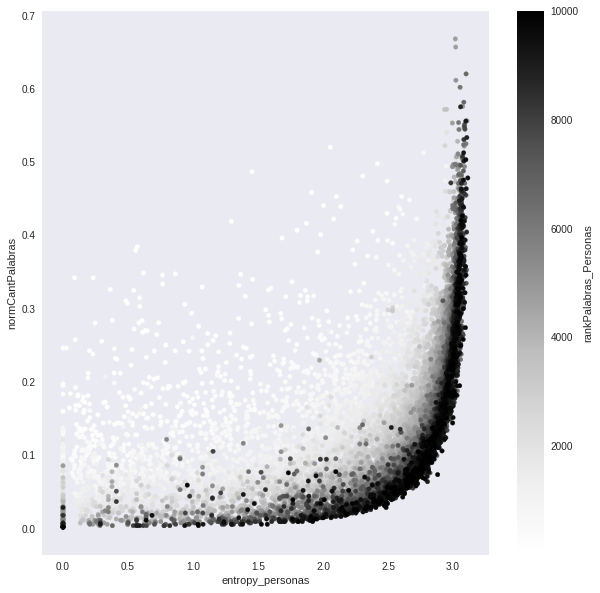

In [27]:
# df.iloc[:1000].plot.scatter(x='entropy_palabras',y='rankPersonas')
# df.iloc[:10000].plot.scatter(x='entropy_palabras',y='rankPalabras')
sns.set_style("dark")
ax = df.iloc[:10000].plot.scatter(x='entropy_personas',y='normCantPalabras',c='rankPalabras_Personas',sharex=False,figsize=(10,10))


## Guardo los listados (resumidos, y extendidos) ordenados en base a las dos médidas de información

In [28]:
df.sort_values(by="information_value_palabras", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed.to_csv('ivalue_entropia_palabras_resumida.csv')
df.to_csv('ivalue_entropia_palabras.csv')

df.sort_values(by="information_value_personas", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed.to_csv('ivalue_entropia_personas_resumida.csv')
df.to_csv('ivalue_entropia_personas.csv')

df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed = resumed[['cantPalabra','esLugar','regionTest','cantUsuariosTotal','fnormArgentina','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas','cantPalabrasWEnRegion','cantPalabrasTotalesEnRegion']]
resumed.to_csv('ivalue_entropia_personas_palabras_resumida.csv')

df.to_csv('ivalue_entropia_personas_palabras.csv')

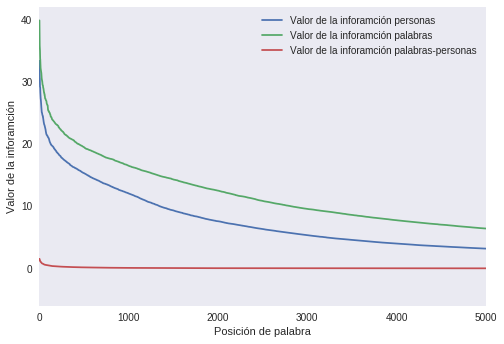

In [29]:
df2 = df.sort_values(by="information_value_personas", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_personas.plot(xlim=[0,5000])
df2 = df.sort_values(by="information_value_palabras", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_palabras.plot(xlim=[0,5000])

df2 = df.sort_values(by="information_value_personas_palabras", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_personas_palabras.plot(xlim=[0,5000])
ax2.legend([u'Valor de la inforamción personas',u'Valor de la inforamción palabras',u'Valor de la inforamción palabras-personas'])


ax2.set_xlabel(u'Posición de palabra')
ax2.set_ylabel(u'Valor de la inforamción')

ax= ax2.get_figure()
ax.savefig("ivalues.svg",dpi=300)

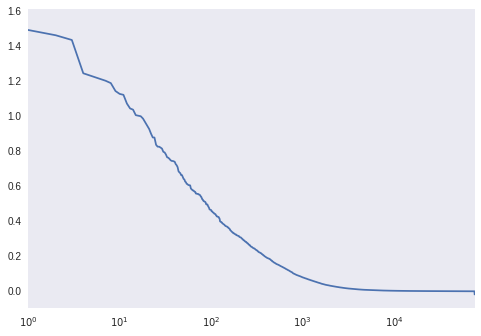

In [30]:
df2 = df.sort_values(by="information_value_personas_palabras", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_personas_palabras.plot(logx=True)

ax= ax2.get_figure()
# ax.savefig("{0}ivaluesLog.pdf".format(relativePathImages),dpi=300)

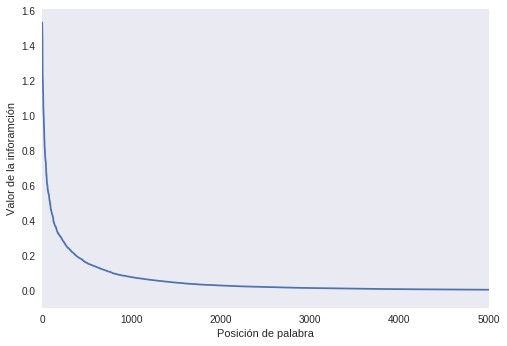

In [31]:
df2 = df.sort_values(by="information_value_personas_palabras", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_personas_palabras.plot(xlim=[0,5000])


ax2.set_xlabel(u'Posición de palabra')
ax2.set_ylabel(u'Valor de la inforamción')

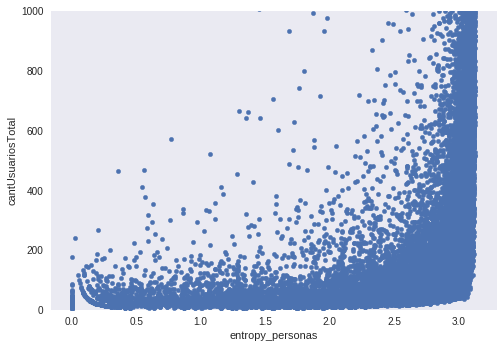

In [32]:
df.plot.scatter(x="entropy_personas", y="cantUsuariosTotal", ylim=[0, 1000])

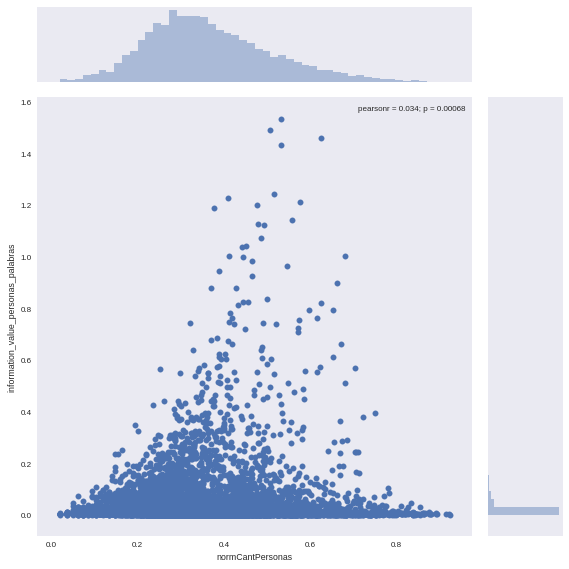

In [33]:
sns.set_context('paper')
sns.jointplot(kind='scatter',x="normCantPersonas", y="information_value_personas_palabras",data=df.iloc[:10000],size=8)

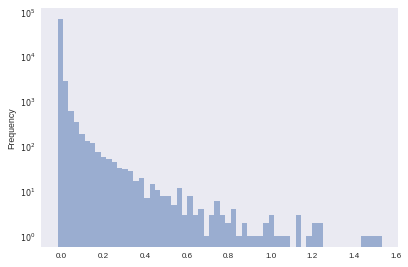

In [34]:
df.information_value_personas_palabras.plot(kind='hist',bins=60,logy=True,alpha=0.5)

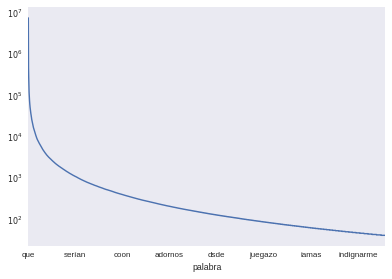

In [35]:
df.cantPalabra.sort_values(ascending=False).plot(x=range(len(df)),logy=True)

In [36]:
sum(df.regionTest.map(lambda x: 'cordoba' in x and 'santafe' in x))

37045

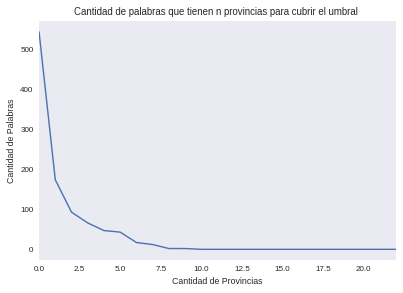

In [37]:
a = []
for i in range(1,24):
    cantProvincias = sum(df[:1000].regionTest.map(lambda x: len(x)==i))
    a.append(cantProvincias)
#     print str(i)+ ': ' + str(cantProvincias)
fig = pd.Series(a).plot(title='Cantidad de palabras que tienen n provincias para cubrir el umbral ')
fig.set_xlabel(xlabel='Cantidad de Provincias')
fig.set_ylabel(ylabel='Cantidad de Palabras')

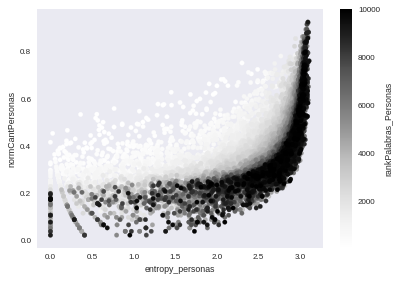

In [38]:
ax = df.iloc[:10000].plot(kind='scatter',x='entropy_personas',y='normCantPersonas',c='rankPalabras_Personas',sharex=False)
ax2= ax.get_figure()
ax2.savefig("{0}entropiaPersonasxNormCantPersonas.pdf".format(relativePathImages),dpi=300)

In [39]:
df.iloc[:5000][df['regionTest'].map(len) > 1 & (df['regionTest'].map(len) < 6) ].regionTest.apply(lambda x : sorted(x[:6])).apply(tuple).value_counts()

/home/dami/tesis/venv/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(jujuy, salta)                                                            24
(mendoza, sanjuan)                                                        19
(neuquen, rionegro)                                                       18
(corrientes, misiones)                                                    16
(chaco, corrientes, formosa)                                              16
(chaco, corrientes)                                                       16
(catamarca, jujuy, larioja, salta, santiago, tucuman)                     15
(chubut, santacruz)                                                       13
(corrientes, formosa, misiones)                                           12
(santacruz, tierradelfuego)                                               12
(corrientes, entrerios, formosa, larioja, misiones)                       12
(catamarca, larioja)                                                      12
(formosa, misiones)                                                       12

In [40]:
df[df.regionTest.map(lambda x: 'jujuy' in x and 'salta' in x )].regionTest

palabra
tribuno                                              [salta, jujuy]
salteño                                              [salta, jujuy]
pue                   [corrientes, formosa, salta, jujuy, santiago]
orán                                                 [salta, jujuy]
tartagal                                             [salta, jujuy]
salteña                                              [salta, jujuy]
martearena                                           [salta, jujuy]
oran                                                 [jujuy, salta]
yuto                                                 [jujuy, salta]
pingo                  [tucuman, santiago, salta, jujuy, catamarca]
perico                           [jujuy, salta, entrerios, sanjuan]
purmamarca                                           [jujuy, salta]
yutos                                                [salta, jujuy]
tilcara           [jujuy, salta, tucuman, entrerios, sanluis, sa...
puna                                    

In [41]:
print 'Hay {0} lugares en las primeras 5000 palabras.'.format(len(df.iloc[:5000][df.iloc[:5000].esLugar == 'lugar']))

Hay 608 lugares en las primeras 5000 palabras.


In [42]:
p1 = df.sort_values(by='information_value_palabras',ascending=False)[:5000].index
p2 =  df.sort_values(by='information_value_personas',ascending=False)[:5000].index
p3 =  df.sort_values(by='information_value_personas_palabras',ascending=False)[:5000].index
interseccion = set(p2) & set(p3) & set(p1)
len(interseccion)

2908

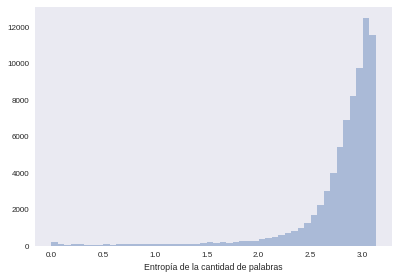

In [43]:
# df.entropy_palabras.plot(kind='hist')
ax = sns.distplot(a=df.entropy_palabras,hist=True,kde=False,axlabel=u'Entropía de la cantidad de palabras')
ax2= ax.get_figure()
ax2.savefig("{0}DistribuciónEntropía.pdf".format(relativePathImages),dpi=300)

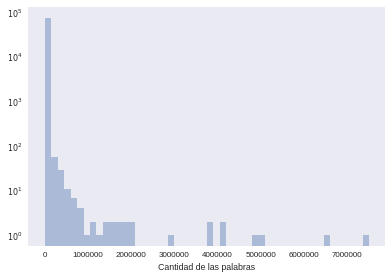

In [44]:
ax = sns.distplot(a=df.cantPalabra,hist=True,kde=False,axlabel=u'Cantidad de las palabras')
ax.set_yscale('log')
ax2 = ax.get_figure()
ax2.savefig("{0}DistribuciónOcurrenciasPalabras.pdf".format(relativePathImages),dpi=300)

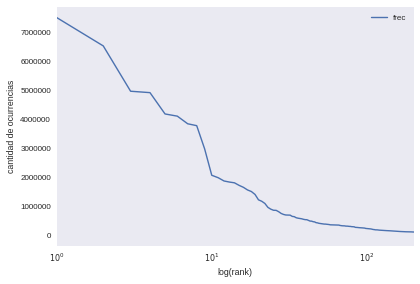

In [45]:
cants = pd.DataFrame(df.cantPalabra)
cantTotal = sum(cants.cantPalabra)
cants = cants.sort_values(by='cantPalabra',ascending=False)
cants['frec'] = cants.cantPalabra
cants['rank'] = cants.cantPalabra.rank(ascending=False)
ax = cants.plot(x='rank',y='frec',logx=True,logy=False,xlim=(0,200))
ax.set_xlabel('log(rank)')
ax.set_ylabel('cantidad de ocurrencias')


In [46]:
from scipy.stats import hypergeom, poisson, norm

dfR = pd.read_csv('../cantidadesDataset.csv',index_col=0)
dfcantPalabrasEnProvincia = pd.read_csv("../contrastes/provincias.csv", quotechar="\"", decimal=",",index_col='palabra')
cant = [c for c in df.columns if re.match(r'.*Palabras$', c) and (not re.match(r'.*norm', c) ) and (not re.match(r'.*rank', c) )]
palabrasEnArgentina = 192348167
def cantPalabrasTotalesEnRegion(provincias):
    return sum(dfR.loc[provincias,'cantTotal'])

def cantPalabrasWEnRegion(palabra,provincias):
    provs = [p+'Palabras' for p in provincias]
    return sum(dfcantPalabrasEnProvincia.loc[palabra,provs])


def cantPalabraWEnArgentina(palabra):
    return dfcantPalabrasEnProvincia.loc[palabra,'cantPalabra']

def calcularPValor(palabra,cantWRegion,cantTotRegion):
    
    M = 192348167 # Cantidad de palabras en toda la Argentina 
    n = dfcantPalabrasEnProvincia.loc[palabra,'cantPalabra'] # Cantidad de palabras w en toda la Argentina 
    N = cantTotRegion # Cantidad de palabras en la region    
    h0 = cantWRegion
    pvalue =  1-hypergeom.cdf(h0, M, n, N) 
    return pvalue


In [47]:
# df['pvalor'] = df.apply(lambda x: calcularPValor(x.name,x.cantPalabrasWEnRegion,x.cantPalabrasTotalesEnRegion), axis=1)
# df.to_csv('PVALORESivalue_entropia_personas_palabras.csv')

In [48]:
pvalores = pd.read_csv('../pvalores.csv')

/home/dami/tesis/venv/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
pvalores.pvalor.describe()

count    7.587700e+04
mean     3.947165e-04
std      1.363955e-02
min      0.000000e+00
25%      8.310303e-18
50%      2.273663e-09
75%      1.935543e-06
max      1.000000e+00
Name: pvalor, dtype: float64

In [50]:
pvalores.iloc[0:10000].pvalor.describe()

count    1.000000e+04
mean     3.192705e-12
std      1.060036e-10
min      0.000000e+00
25%      2.803732e-86
50%      3.555913e-41
75%      1.476985e-24
max      5.565337e-09
Name: pvalor, dtype: float64

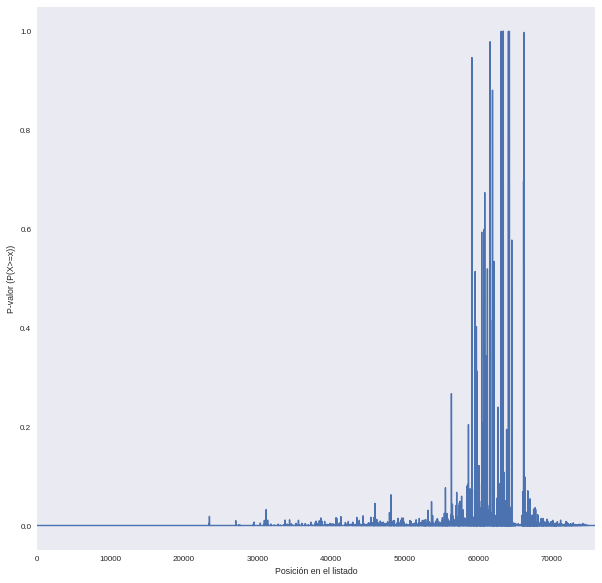

In [51]:
f = pvalores.dropna().pvalor.plot(figsize=(10,10))
f.set_xlabel(u'Posición en el listado')
f.set_ylabel(u'P-valor (P(X>=x))')

f.get_figure().savefig('pvalores.png')

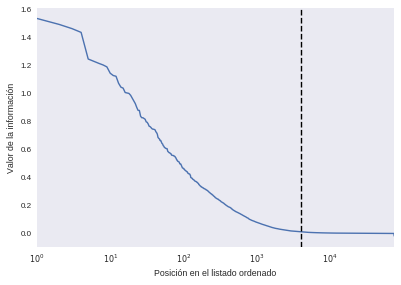

In [52]:
ax=df.plot(x='rankPalabras_Personas',y='information_value_personas_palabras',logx=True,legend=False)
ax.axvline(4000, linestyle='--', color='k')
ax.set_xlabel(u'Posición en el listado ordenado')
ax.set_ylabel(u'Valor de la información')
# ax.get_figure().savefig("{0}valorInformacionCorte".format(relativePathImages),dpi=300)

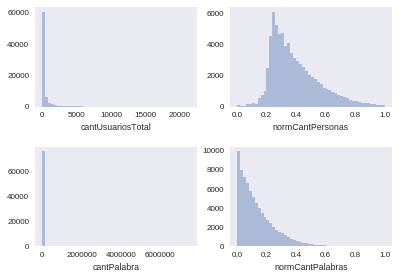

In [105]:
sns.set_context('paper')
fig, axes = plt.subplots(ncols=2,nrows=2,sharey=False)
sns.distplot(df.cantUsuariosTotal,kde=False,ax=axes[0,0])
sns.distplot(df.normCantPersonas,kde=False,ax=axes[0,1])
sns.distplot(df.cantPalabra,kde=False,ax=axes[1,0])
sns.distplot(df.normCantPalabras,kde=False,ax=axes[1,1])
fig.subplots_adjust(hspace=.4)
# axes[0,0].set(xlabel='Cantidad de ocurrencias', ylabel='')
fig.savefig("{0}cantNorms.pdf".format(relativePathImages),dpi=300)